In [1]:
import mne
import pyedflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
file = "projects/ctb-akhanf/cfmm-bids/Khan/epi_iEEG/ieeg/bids/sub-002/ses-002/ieeg/sub-002_ses-002_task-full_run-01_ieeg.edf"
f = pyedflib.EdfReader(file)

In [28]:
labels = f.getSignalLabels()

In [17]:
# n_annot = len(f.readAnnotations()[0])
# annot = np.zeros([n_annot, 3])
annot = f.readAnnotations()
annot = {
    'Duration': annot[0],
    'time_rel': annot[1],
    'event': annot[2]
}
annot = pd.DataFrame(annot)
annot.head()

,Duration,time_rel,event
0,0.009766,-1.0,Breakout box reconnected.
1,157.500977,-1.0,Patient Event
2,173.684570,-1.0,Patient Event
3,198.474609,-1.0,Patient Event
4,201.696289,-1.0,Patient Event


In [24]:
# Find time stamps where the 'awake trigger' event is happening
id = annot['event'].str.contains('awake trigger', case=False)
time_stamps = annot.Duration.to_numpy()[id]

In [68]:
time_stamps.size

1

In [ ]:
# Use hd5
# Extract the signal info:
f = h5py.File("scratch/mytestfile.hdf5", "w")
data_grp = f.create_group('data')
if time_stamps.size > 0:
    # First create an empty array for it:
    N = f.getNSamples()[0]
    m = time_stamps.size
    # Time vector:
    srate = f.getSampleFrequencies()[0]
    t = np.arange(0, N)/srate
    # Build epochs
    for chn in range(len(labels)):
        # Read signal
        signal = f.readSignal(chn)
        epoch = np.array([], dtype=float)
        for epoch_id in range(m):
            t_init = np.argmin(np.square(t-time_stamps[epoch_id])) ## CANNOT BE ZERO, change to a not magic #
            t_end = t_init+240*srate # 4 min = 240 s
            epoch = np.hstack([epoch, signal[t_init:t_end], np.zeros(int(60*srate))])
        data_grp.create_dataset(f'{labels[chn]}', data=epoch)
f.close()

In [43]:
signal = f.readSignal(0)

In [62]:
N = signal.shape[0]
srate = f.getSampleFrequencies()[0]
t = np.arange(0, N)/srate
t_init = np.argmin(np.square(t-time_stamps[0]))
t_end = t_init+240*srate # 4 min = 240 s
epoch = signal[t_init:t_end]

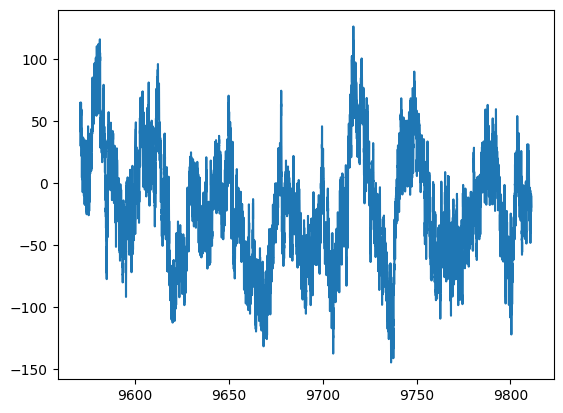

In [63]:
fig, ax = plt.subplots()
ax.plot(t[t_init:t_end], epoch)